In [3]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [4]:
dataset= FashionMNIST(root='data/', train=True, transform= transforms.ToTensor(), download= True)
len(dataset)

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


60000

In [5]:
train_ds, val_ds= random_split(dataset, [50000,10000])

test_ds= FashionMNIST(root='data/', train=False, transform= transforms.ToTensor())

batch_size=128
train_loader= DataLoader(train_ds, batch_size, shuffle=True)
val_loader= DataLoader(val_ds, batch_size*2)
test_loader= DataLoader(test_ds, batch_size*2)

7


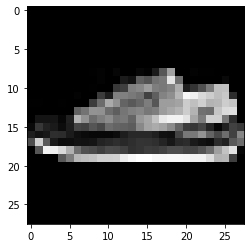

In [9]:
image, label= train_ds[40]
plt.imshow(image[0], cmap='gray')
print(label)

In [23]:
label_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

## Model

In [24]:
class FashionMnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = FashionMnistModel()

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Evaluate

In [27]:
evaluate(model, val_loader)

{'val_acc': 0.07021484524011612, 'val_loss': 2.3368937969207764}

In [28]:
historyFinal=[]

In [36]:
history=fit(2, 0.01, model, train_loader, val_loader)
historyFinal.extend(history)

Epoch [0], val_loss: 0.4566, val_acc: 0.8477
Epoch [1], val_loss: 0.4552, val_acc: 0.8479


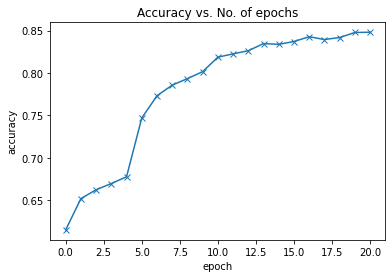

In [37]:
accuracies = [r['val_acc'] for r in historyFinal]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [38]:
# test_data
evaluate(model, test_loader)

{'val_acc': 0.838183581829071, 'val_loss': 0.4656878411769867}

## Prediction

In [39]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 3  (Dress) , Predicted: 3  (Dress)


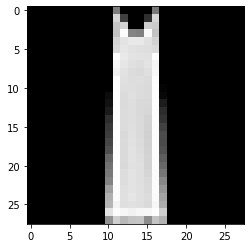

In [42]:
img, label = test_ds[918]
plt.imshow(img[0], cmap='gray')
print('Label:', label,' ('+str(label_names[label])+')', ', Predicted:', predict_image(img, model),' ('+str(label_names[predict_image(img, model)])+')')